In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from ase.io import write
from adis_tools.parsers import parse_pw
from pyiron_base import job, Project
from pyiron_base.project.delayed import draw, DelayedObject

In [2]:
def remove_server_obj(nodes_dict, edges_lst):
    server_lst = [k for k in nodes_dict.keys() if k.startswith("server_obj_")]
    for s in server_lst:
        del nodes_dict[s]
        edges_lst = [ep for ep in edges_lst if s not in ep]
    return nodes_dict, edges_lst

In [3]:
def get_nodes(connection_dict, delayed_object_updated_dict):
    return {
        connection_dict[k]: v._python_function if isinstance(v, DelayedObject) else v
        for k, v in delayed_object_updated_dict.items()
    }

In [4]:
def get_unique_objects(nodes_dict, edges_lst):  # I need a pre-filter before this function to remove the virtual nodes
    delayed_object_dict = {}
    for k, v in nodes_dict.items():
        if isinstance(v, DelayedObject):
            delayed_object_dict[k] = v
        elif isinstance(v, list) and any([isinstance(el, DelayedObject) for el in v]):  # currently this replaces any list - what I need instead is some kind of virtual node - mixed nodes
            delayed_object_dict[k] = DelayedObject(function=get_list)
            delayed_object_dict[k]._input = {i: el for el in enumerate(v)}
            delayed_object_dict[k]._python_function = get_list
        elif isinstance(v, dict) and any([isinstance(el, DelayedObject) for el in v.values()]):
            delayed_object_dict[k] = DelayedObject(function=get_dict, **v,)
            delayed_object_dict[k]._python_function = get_dict
            delayed_object_dict[k]._input = v
    unique_lst = []
    delayed_object_updated_dict, match_dict = {}, {}
    for dobj in delayed_object_dict.keys():
        match = False
        for obj in unique_lst:
            # print(delayed_object_dict[dobj]._list_index, delayed_object_dict[dobj]._output_key, delayed_object_dict[obj]._list_index, delayed_object_dict[obj]._output_key)
            if obj.split("_")[0] == dobj.split("_")[0] and delayed_object_dict[dobj]._input == delayed_object_dict[obj]._input:
                delayed_object_updated_dict[obj] = delayed_object_dict[obj]
                match_dict[dobj] = obj
                match = True
                break
        if not match:
            unique_lst.append(dobj)
            delayed_object_updated_dict[dobj] = delayed_object_dict[dobj]
    update_dict = {}
    for k, v in nodes_dict.items():
        if not (isinstance(v, DelayedObject) or (isinstance(v, list) and any([isinstance(el, DelayedObject) for el in v])) or (isinstance(v, dict) and any([isinstance(el, DelayedObject) for el in v.values()]))):
            update_dict[k] = v
    delayed_object_updated_dict.update(update_dict)
    return delayed_object_updated_dict, match_dict

In [5]:
def get_connection_dict(delayed_object_updated_dict, match_dict):
    new_obj_dict = {}
    connection_dict = {}
    lookup_dict = {}
    for i, [k, v] in enumerate(delayed_object_updated_dict.items()):
        new_obj_dict[i] = v
        connection_dict[k] = i
        lookup_dict[i] = k
    
    for k, v in match_dict.items():
        if v in connection_dict.keys():
            connection_dict[k] = connection_dict[v]

    return connection_dict, lookup_dict


In [6]:
def get_edges_dict(edges_lst, nodes_dict, connection_dict, lookup_dict):
    edges_dict_lst = []
    existing_connection_lst = []
    for ep in edges_lst:
        input_name, output_name = ep
        target = connection_dict[input_name]
        target_handle = "_".join(output_name.split("_")[:-1])
        connection_name = lookup_dict[target] + "_" + target_handle
        if connection_name not in existing_connection_lst:
            output = nodes_dict[output_name]
            if isinstance(output, DelayedObject):
                if output._list_index is not None:
                    edges_dict_lst.append({
                        "target": target,
                        "targetHandle": target_handle,
                        "source": connection_dict[output_name],
                        "sourceHandle": output._list_index,  # check for list index 
                    })
                else:
                    edges_dict_lst.append({
                        "target": target,
                        "targetHandle": target_handle,
                        "source": connection_dict[output_name],
                        "sourceHandle": output._output_key,  # check for list index 
                    })
            else:
                edges_dict_lst.append({
                    "target": target,
                    "targetHandle": target_handle,
                    "source": connection_dict[output_name],
                    "sourceHandle": None,
                })
            existing_connection_lst.append(connection_name)
    return edges_dict_lst


In [7]:
def get_dict(**kwargs):
    return {k: v for k, v in kwargs["kwargs"].items()}

In [8]:
def get_list(**kwargs):
    return list(kwargs["kwargs"].values())

In [9]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, "input.pwi")
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename,
        images=input_dict["structure"],
        Crystal=True,
        kpts=input_dict["kpts"],
        input_data={
            "calculation": input_dict["calculation"],
            "occupations": "smearing",
            "degauss": input_dict["smearing"],
        },
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True,
        tprnfor=True,
    )

In [10]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, "pwscf.xml"))
    return {
        "structure": output["ase_structure"],
        "energy": output["energy"],
        "volume": output["ase_structure"].get_volume(),
    }

In [11]:
@job(output_key_lst=["energy", "volume", "structure"])
def calculate_qe(working_directory, input_dict):
    write_input(
        input_dict=input_dict,
        working_directory=working_directory,
    )
    subprocess.check_output(
        "mpirun -np 1 pw.x -in input.pwi > output.pwo",
        cwd=working_directory,
        shell=True,
    )
    return collect_output(working_directory=working_directory)

In [12]:
@job
def generate_structures(structure, strain_lst):
    structure_lst = []
    for strain in strain_lst:
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain ** (1 / 3), scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return structure_lst

In [13]:
@job
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [14]:
@job
def get_bulk_structure(name, a, cubic):
    return bulk(
        name=name,
        a=a,
        cubic=cubic,
    )

In [15]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [16]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
structure = get_bulk_structure(
    name="Al",
    a=4.05,
    cubic=True,
    pyiron_project=pr,
)

In [18]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
    pyiron_project=pr,
)

In [19]:
number_of_strains = 5
structure_lst = generate_structures(  # the generate_structures() function is not available in the workflow graph
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
    pyiron_project=pr,
    list_length=number_of_strains,
)

In [20]:
energy_lst, volume_lst = [], []
for i, structure_strain in enumerate(structure_lst):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": structure_strain,
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
        pyiron_project=pr,
    )
    energy_lst.append(calc_strain.output.energy)
    volume_lst.append(calc_strain.output.volume)

In [21]:
plot = plot_energy_volume_curve(
    volume_lst=volume_lst,
    energy_lst=energy_lst,
    pyiron_project=pr,
)

This concludes the first version of the simulation workflow, in the following the submission to HPC resources, the different options for data storage and the publication of the workflow are briefly discussed.

The job get_bulk_structure_ef8044c5c6b530c2cb8fcd81c0a48046 was saved and received the ID: 1988
The job calculate_qe_82fd5a937584aec291cc67da3197a072 was saved and received the ID: 1989


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_f6b43bd253cb129fabd8fd383f7194a6 was saved and received the ID: 1990
The job calculate_qe_8e30db1eddb80d50c4c02cde42ad3f2d was saved and received the ID: 1991


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_d95b08c4d5648e3887866fab89d91ad2 was saved and received the ID: 1992


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_20420f9206ac8a06c5ae3933ba4c3f1a was saved and received the ID: 1993


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_9b5cae7de2a902b8dbe54bb158a6c721 was saved and received the ID: 1994


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job calculate_qe_188c4b0db846141db0ceeb6df77a74ca was saved and received the ID: 1995


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job plot_energy_volume_curve_c32682c20c156b29ef242b8c5d264acb was saved and received the ID: 1996


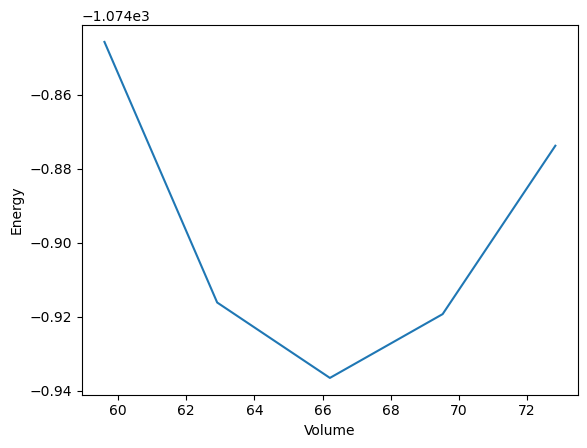

In [22]:
plot.pull()

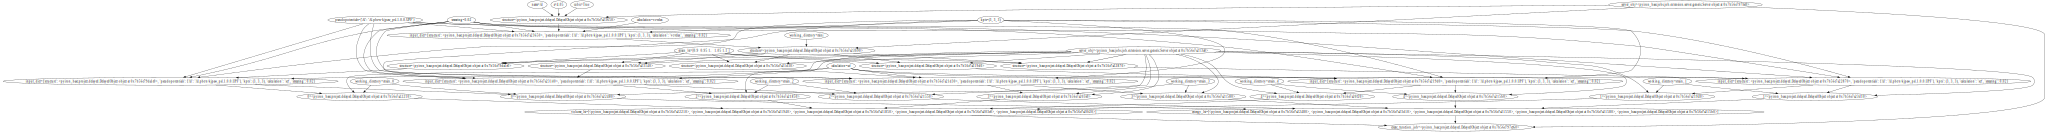

In [23]:
plot.draw()

In [24]:
nodes_dict, edges_lst = plot.get_graph()

In [25]:
nodes_dict, edges_lst = remove_server_obj(nodes_dict=nodes_dict, edges_lst=edges_lst)

In [26]:
delayed_object_updated_dict, match_dict = get_unique_objects(nodes_dict=nodes_dict, edges_lst=edges_lst)

In [27]:
connection_dict, lookup_dict = get_connection_dict(delayed_object_updated_dict=delayed_object_updated_dict, match_dict=match_dict)

In [28]:
nodes_new_dict = get_nodes(connection_dict=connection_dict, delayed_object_updated_dict=delayed_object_updated_dict)
nodes_new_dict

{0: <function __main__.plot_energy_volume_curve(volume_lst, energy_lst)>,
 1: <function __main__.get_list(**kwargs)>,
 2: <function __main__.calculate_qe(working_directory, input_dict)>,
 3: <function __main__.get_dict(**kwargs)>,
 4: <function __main__.generate_structures(structure, strain_lst)>,
 5: <function __main__.calculate_qe(working_directory, input_dict)>,
 6: <function __main__.get_dict(**kwargs)>,
 7: <function __main__.get_bulk_structure(name, a, cubic)>,
 8: <function __main__.calculate_qe(working_directory, input_dict)>,
 9: <function __main__.get_dict(**kwargs)>,
 10: <function __main__.calculate_qe(working_directory, input_dict)>,
 11: <function __main__.get_dict(**kwargs)>,
 12: <function __main__.calculate_qe(working_directory, input_dict)>,
 13: <function __main__.get_dict(**kwargs)>,
 14: <function __main__.calculate_qe(working_directory, input_dict)>,
 15: <function __main__.get_dict(**kwargs)>,
 16: <function __main__.get_list(**kwargs)>,
 17: 'strain_0',
 18: 'mi

In [29]:
edges_new_lst = get_edges_dict(edges_lst=edges_lst, nodes_dict=nodes_dict, connection_dict=connection_dict, lookup_dict=lookup_dict)
edges_new_lst

[{'target': 0,
  'targetHandle': 'volume_lst',
  'source': 1,
  'sourceHandle': None},
 {'target': 1, 'targetHandle': '0', 'source': 2, 'sourceHandle': 'volume'},
 {'target': 2,
  'targetHandle': 'working_directory',
  'source': 17,
  'sourceHandle': None},
 {'target': 2,
  'targetHandle': 'input_dict',
  'source': 3,
  'sourceHandle': None},
 {'target': 3, 'targetHandle': 'structure', 'source': 4, 'sourceHandle': 0},
 {'target': 4,
  'targetHandle': 'structure',
  'source': 5,
  'sourceHandle': 'structure'},
 {'target': 5,
  'targetHandle': 'working_directory',
  'source': 18,
  'sourceHandle': None},
 {'target': 5,
  'targetHandle': 'input_dict',
  'source': 6,
  'sourceHandle': None},
 {'target': 6, 'targetHandle': 'structure', 'source': 7, 'sourceHandle': None},
 {'target': 7, 'targetHandle': 'name', 'source': 19, 'sourceHandle': None},
 {'target': 7, 'targetHandle': 'a', 'source': 20, 'sourceHandle': None},
 {'target': 7, 'targetHandle': 'cubic', 'source': 21, 'sourceHandle': None